# Multilingual speech-to-speech translation system

In [79]:
import os
import numpy as np
import librosa
import joblib
import webrtcvad
import soundfile as sf
from sklearn.metrics import confusion_matrix, accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
import joblib
import re
from pydub import AudioSegment

## ENTRAINEMENT

### Suppression du silence

In [81]:
def remove_silence(audio, sr=16000, aggressiveness=3, frame_duration=30):
    vad = webrtcvad.Vad(aggressiveness)
    frame_len = int(sr * frame_duration / 1000)
    offset = 0
    voiced = []

    while offset + frame_len < len(audio):
        frame = audio[offset:offset + frame_len]
        pcm = (frame * 32768).astype(np.int16).tobytes()
        if vad.is_speech(pcm, sample_rate=sr):
            voiced.extend(frame)
        offset += frame_len

    return np.array(voiced)

def process_audio_folder(input_dir, output_dir, sr=16000):
    os.makedirs(output_dir, exist_ok=True)

    for filename in os.listdir(input_dir):
        if filename.lower().endswith(".wav"):
            input_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, filename)

            try:
                audio, _ = librosa.load(input_path, sr=sr)
                cleaned_audio = remove_silence(audio, sr)
                if len(cleaned_audio) > 0:
                    sf.write(output_path, cleaned_audio, sr)
                else:
                    print(f"[!] Skipped (silent): {filename}")
            except Exception as e:
                print(f"[✗] Failed: {filename} — {e}")


### Extraction des MFCCS 

In [85]:
def extract_mfcc_from_folder(input_dir, output_dir, sr=16000, n_mfcc=13):
    os.makedirs(output_dir, exist_ok=True)

    for filename in os.listdir(input_dir):
        if filename.lower().endswith(".wav"):
            input_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, filename.replace(".wav", ".npy"))

            try:
                # 1. Load audio
                y, _ = librosa.load(input_path, sr=sr)

                # 2. Extract MFCCs
                mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

                # 3. (Optional) Add delta and delta-delta
                delta = librosa.feature.delta(mfcc)
                delta2 = librosa.feature.delta(mfcc, order=2)
                mfcc_all = np.vstack([mfcc, delta, delta2])  # shape: (n_mfcc*3, T)

                # 4. Save as .npy
                np.save(output_path, mfcc_all.T)  # shape: (T, n_features)

            except Exception as e:
                print(f"[✗] Failed on {filename}: {e}")

### Normalisation of MFCCs

In [54]:
def apply_cmvn_to_dataset(input_dir, output_dir):
    
    def apply_cmvn(mfcc):
        mean = np.mean(mfcc, axis=0)
        std = np.std(mfcc, axis=0)
        return (mfcc - mean) / (std + 1e-8)

    os.makedirs(output_dir, exist_ok=True)

    for language in os.listdir(input_dir):
        lang_path = os.path.join(input_dir, language)
        if not os.path.isdir(lang_path):
            continue

        out_lang_path = os.path.join(output_dir, language)
        os.makedirs(out_lang_path, exist_ok=True)

        for file_name in os.listdir(lang_path):
            if file_name.endswith('.npy'):
                file_path = os.path.join(lang_path, file_name)
                mfcc = np.load(file_path)

                # Apply CMVN
                mfcc_norm = apply_cmvn(mfcc)

                # Save to output folder
                out_file_path = os.path.join(out_lang_path, file_name)
                np.save(out_file_path, mfcc_norm)

    print(f"✅ CMVN applied from '{input_dir}' to '{output_dir}'")

In [56]:
apply_cmvn_to_dataset(r"C:\Users\wiame\Documents\1_SEMESTER_8\SYNTHESE VOCALE\PROJECT\MFCCS", 
                      r"C:\Users\wiame\Documents\1_SEMESTER_8\SYNTHESE VOCALE\PROJECT\MFCCS_normalized")

✅ CMVN applied from 'C:\Users\wiame\Documents\1_SEMESTER_8\SYNTHESE VOCALE\PROJECT\MFCCS' to 'C:\Users\wiame\Documents\1_SEMESTER_8\SYNTHESE VOCALE\PROJECT\MFCCS_normalized'


### Entrainement des modèles

In [65]:
def load_mfccs(folder_path):
    mfcc_list = []
    for fname in os.listdir(folder_path):
        if fname.endswith(".npy"):
            mfcc = np.load(os.path.join(folder_path, fname))
            mfcc_list.append(mfcc)
    return np.vstack(mfcc_list)

def train_gmms(data_root, output_dir, n_components_list=[8, 16, 32, 64, 128, 256]):
    os.makedirs(output_dir, exist_ok=True)
    languages = [d for d in os.listdir(data_root) if os.path.isdir(os.path.join(data_root, d))]

    for n_components in n_components_list:
        print(f"\n🔧 Training GMMs with {n_components} Gaussians")

        for lang in languages:
            lang_path = os.path.join(data_root, lang)
            features = load_mfccs(lang_path)

            print(f"  → Training for language: {lang} ({features.shape[0]} frames)")

            gmm = GaussianMixture(n_components=n_components, covariance_type='diag', max_iter=100, random_state=42)
            gmm.fit(features)

            model_path = os.path.join(output_dir, f"{lang}_gmm_{n_components}.joblib")
            joblib.dump(gmm, model_path)
            print(f"    [✓] Saved model: {model_path}")

In [ ]:
data_root = r"C:\Users\wiame\Documents\1_SEMESTER_8\SYNTHESE VOCALE\PROJECT\MFCCS_normalized"        # Contains arabic etc.
model_save_path = r"C:\Users\wiame\Documents\1_SEMESTER_8\SYNTHESE VOCALE\PROJECT\GMM_models_normalized"     # Output folder for GMMs

train_gmms(data_root, model_save_path, n_components_list=[512, 1024])


🔧 Training GMMs with 512 Gaussians
  → Training for language: Arabic (203981 frames)
    [✓] Saved model: C:\Users\wiame\Documents\1_SEMESTER_8\SYNTHESE VOCALE\PROJECT\GMM_models_normalized\Arabic_gmm_512.joblib
  → Training for language: Darija (229854 frames)


## TEST

In [96]:
# Same silence removal as in training
def remove_silence(audio, sr=16000, aggressiveness=3, frame_duration=30):
    vad = webrtcvad.Vad(aggressiveness)
    frame_len = int(sr * frame_duration / 1000)
    offset = 0
    voiced = []

    while offset + frame_len < len(audio):
        frame = audio[offset:offset + frame_len]
        pcm = (frame * 32768).astype(np.int16).tobytes()
        if vad.is_speech(pcm, sample_rate=sr):
            voiced.extend(frame)
        offset += frame_len

    return np.array(voiced)

# Feature extraction using VAD 
def extract_features(file_path, sr=16000, n_mfcc=13):
    y, _ = librosa.load(file_path, sr=sr)

    # Apply silence removal
    y_clean = remove_silence(y, sr=sr)

    if len(y_clean) == 0:
        return np.zeros((1, n_mfcc * 3))

    mfcc = librosa.feature.mfcc(y=y_clean, sr=sr, n_mfcc=n_mfcc)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    mfcc_all = np.vstack([mfcc, delta, delta2])  # shape: (39, T)

    # Apply Cepstral Mean and Variance Normalization (CMVN)
    mfcc_all = (mfcc_all - np.mean(mfcc_all, axis=1, keepdims=True)) / (np.std(mfcc_all, axis=1, keepdims=True) + 1e-10)

    return mfcc_all.T  # shape: (T, 39)

# Evaluation loop 
def evaluate_gmm_models(test_path, model_path, n_components_list=[8, 16, 32, 64, 128, 256, 512]):
    class_names = [d for d in os.listdir(test_path) if os.path.isdir(os.path.join(test_path, d))]
    class_names = [name.lower() for name in class_names]
    label_map = {name: idx for idx, name in enumerate(sorted(class_names))}
    inv_label_map = {v: k for k, v in label_map.items()} 

    file_paths = []
    true_labels = []
    for lang in class_names:
        full_path = os.path.join(test_path, lang)
        for file in os.listdir(full_path):
            if file.endswith(".wav"):
                file_paths.append(os.path.join(full_path, file))
                true_labels.append(label_map[lang])

    true_labels = np.array(true_labels)

    for n_comp in n_components_list:
        print(f"\nEvaluating GMM models with {n_comp} components...")
        gmm_models = {}
        for lang in class_names:
            model_filename = f"{lang.capitalize()}_gmm_{n_comp}.joblib"
            model_file = os.path.join(model_path, model_filename)
            if os.path.exists(model_file):
                gmm_models[lang] = joblib.load(model_file)
            else:
                print(f"Model not found: {model_file}")

        predictions = []
        misclassified_files = []

        for idx, path in enumerate(tqdm(file_paths, desc=f"Testing {n_comp} components")):
            features = extract_features(path)
            scores = {lang: model.score(features) for lang, model in gmm_models.items()}
            predicted_lang = max(scores, key=scores.get)
            predictions.append(label_map[predicted_lang])

            # Check misclassification
            if label_map[predicted_lang] != true_labels[idx]:
                true_lang_name = inv_label_map[true_labels[idx]]
                pred_lang_name = predicted_lang
                misclassified_files.append(
                    (os.path.basename(path), true_lang_name, pred_lang_name)
                )

        acc = accuracy_score(true_labels, predictions)
        cm = confusion_matrix(true_labels, predictions)
        print(f"Accuracy with {n_comp} Gaussians: {acc*100:.2f}%")
        # print("Confusion Matrix:")
        # print(cm)

        # if misclassified_files:
        #     print(f"\nMisclassified audio files for {n_comp} components:")
        #     for fname, true_label, pred_label in misclassified_files:
        #         print(f"  File: {fname}, True: {true_label}, Predicted: {pred_label}")
        # else:
        #     print("No misclassifications!")

        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=sorted(label_map.keys()),
                    yticklabels=sorted(label_map.keys()))
        plt.title(f"Confusion Matrix for GMM with {n_comp} Components")
        plt.xlabel("Predicted Language")
        plt.ylabel("True Language")
        plt.show()

### Accuracy de l'entrainement


Evaluating GMM models with 8 components...


Testing 8 components: 100%|██████████████████████████████████████████████████████████| 240/240 [03:56<00:00,  1.01it/s]


Accuracy with 8 Gaussians: 87.08%


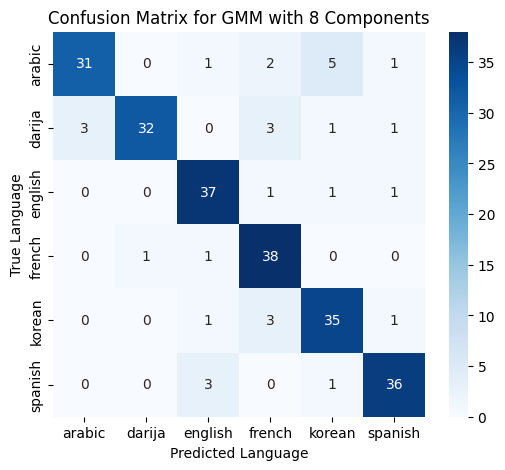


Evaluating GMM models with 16 components...


Testing 16 components: 100%|█████████████████████████████████████████████████████████| 240/240 [04:22<00:00,  1.10s/it]


Accuracy with 16 Gaussians: 90.42%


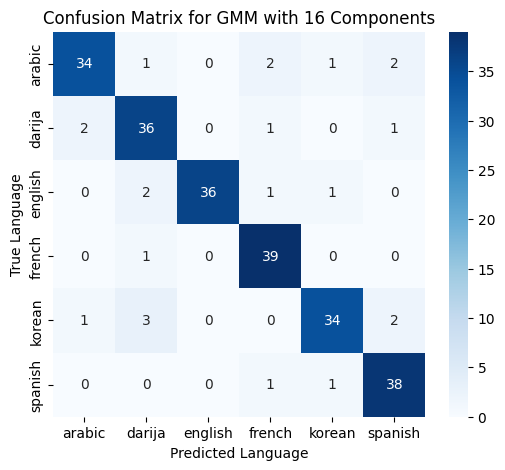


Evaluating GMM models with 32 components...


Testing 32 components: 100%|█████████████████████████████████████████████████████████| 240/240 [04:32<00:00,  1.13s/it]


Accuracy with 32 Gaussians: 94.58%


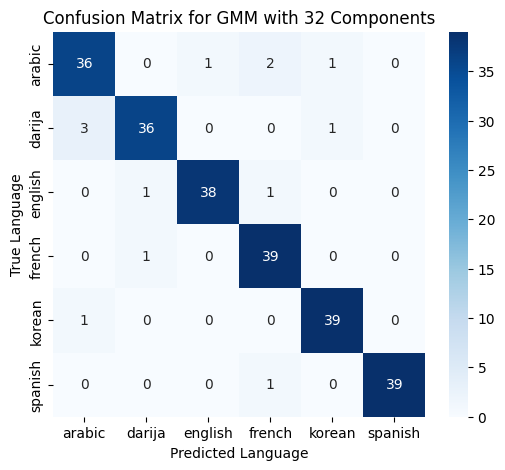


Evaluating GMM models with 64 components...


Testing 64 components: 100%|█████████████████████████████████████████████████████████| 240/240 [04:28<00:00,  1.12s/it]


Accuracy with 64 Gaussians: 97.50%


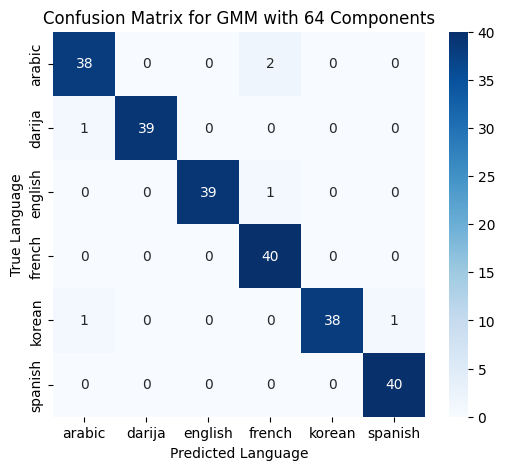


Evaluating GMM models with 128 components...


Testing 128 components: 100%|████████████████████████████████████████████████████████| 240/240 [04:56<00:00,  1.24s/it]


Accuracy with 128 Gaussians: 99.17%


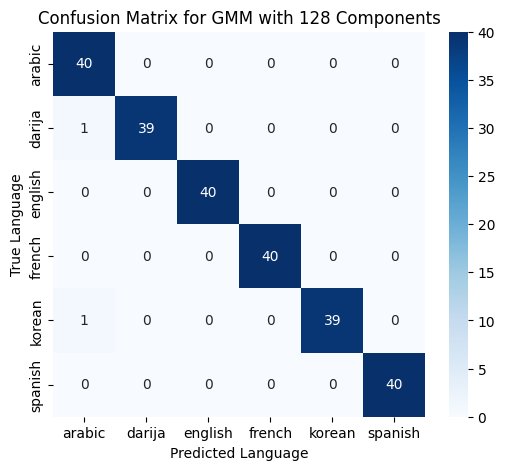


Evaluating GMM models with 256 components...


Testing 256 components: 100%|████████████████████████████████████████████████████████| 240/240 [05:49<00:00,  1.46s/it]


Accuracy with 256 Gaussians: 100.00%


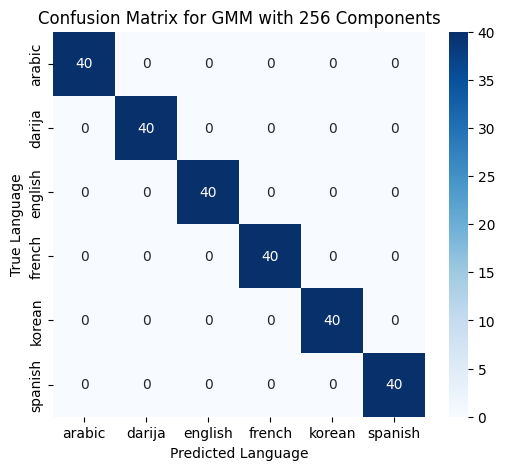


Evaluating GMM models with 512 components...


Testing 512 components: 100%|████████████████████████████████████████████████████████| 240/240 [10:44<00:00,  2.69s/it]


Accuracy with 512 Gaussians: 100.00%


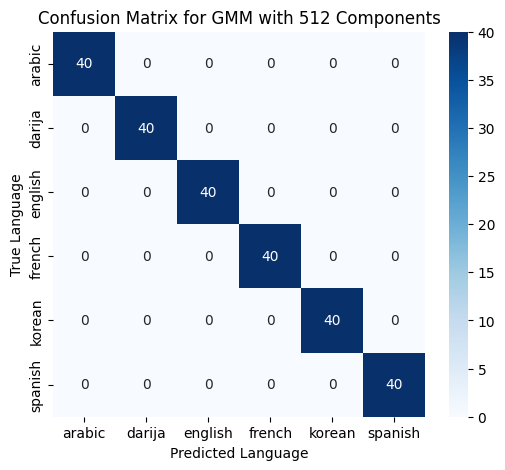


Evaluating GMM models with 1024 components...


Testing 1024 components: 100%|███████████████████████████████████████████████████████| 240/240 [24:45<00:00,  6.19s/it]


Accuracy with 1024 Gaussians: 100.00%


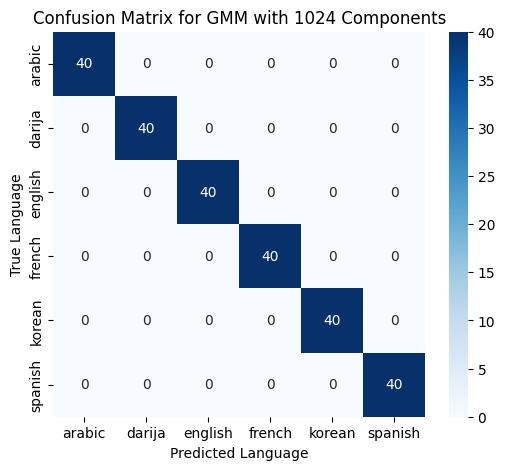

In [98]:
test_data_root = r"C:\Users\wiame\Documents\1_SEMESTER_8\SYNTHESE VOCALE\PROJECT\Training audios" 
model_dir = r"C:\Users\wiame\Documents\1_SEMESTER_8\SYNTHESE VOCALE\PROJECT\GMM_models_normalized"
results = evaluate_gmm_models(test_data_root, model_dir, n_components_list=[8, 16, 32, 64, 128, 256, 512, 1024])

### Accuracy du test avec 4 langues


Evaluating GMM models with 8 components...


Testing 8 components: 100%|██████████████████████████████████████████████████████████| 160/160 [00:54<00:00,  2.95it/s]


Accuracy with 8 Gaussians: 79.38%


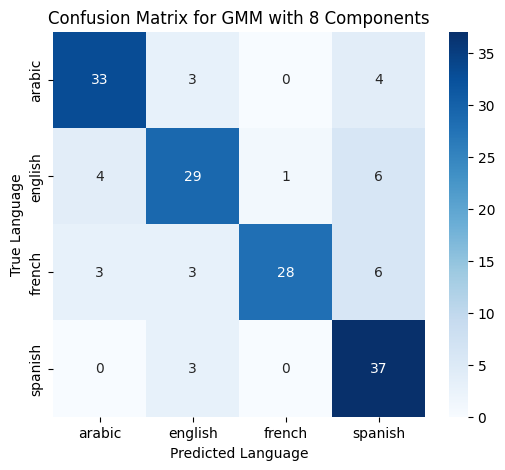


Evaluating GMM models with 16 components...


Testing 16 components: 100%|█████████████████████████████████████████████████████████| 160/160 [00:50<00:00,  3.17it/s]


Accuracy with 16 Gaussians: 83.12%


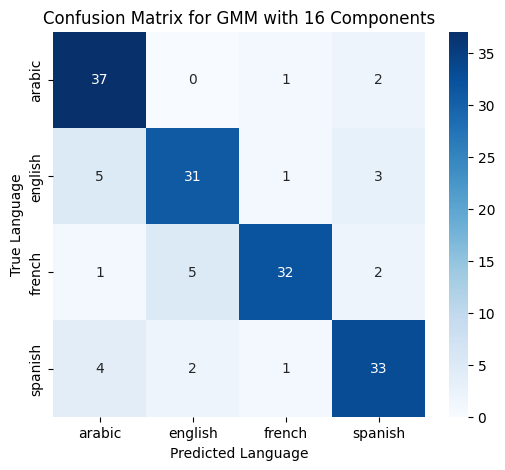


Evaluating GMM models with 32 components...


Testing 32 components: 100%|█████████████████████████████████████████████████████████| 160/160 [00:48<00:00,  3.27it/s]


Accuracy with 32 Gaussians: 83.12%


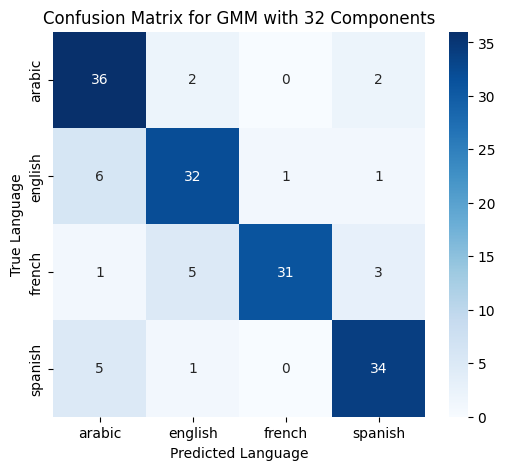


Evaluating GMM models with 64 components...


Testing 64 components: 100%|█████████████████████████████████████████████████████████| 160/160 [00:47<00:00,  3.36it/s]


Accuracy with 64 Gaussians: 86.88%


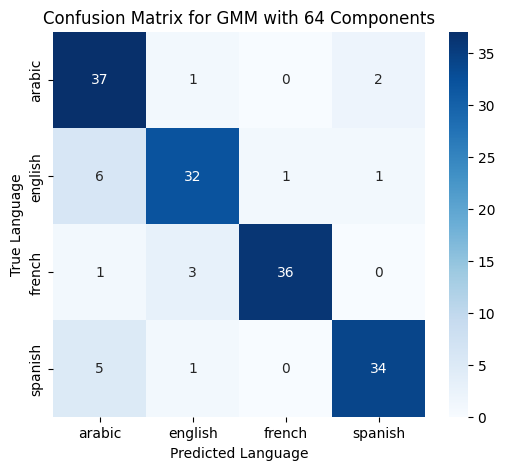


Evaluating GMM models with 128 components...


Testing 128 components: 100%|████████████████████████████████████████████████████████| 160/160 [00:51<00:00,  3.09it/s]


Accuracy with 128 Gaussians: 90.62%


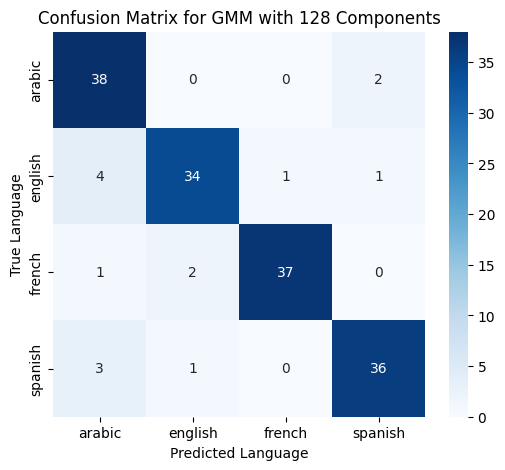


Evaluating GMM models with 256 components...


Testing 256 components: 100%|████████████████████████████████████████████████████████| 160/160 [00:59<00:00,  2.70it/s]


Accuracy with 256 Gaussians: 91.25%


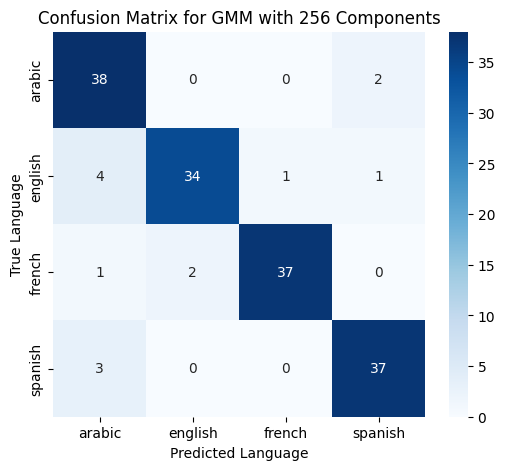


Evaluating GMM models with 512 components...


Testing 512 components: 100%|████████████████████████████████████████████████████████| 160/160 [01:14<00:00,  2.16it/s]


Accuracy with 512 Gaussians: 92.50%


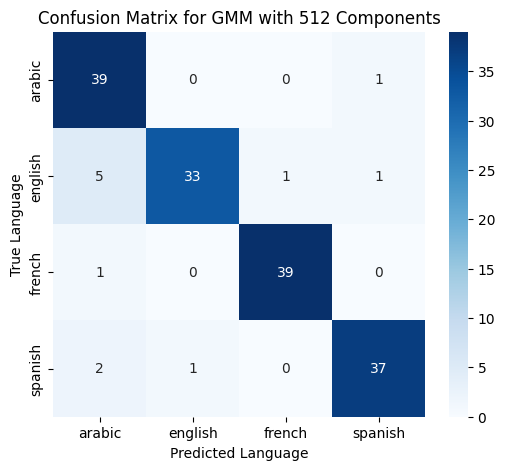


Evaluating GMM models with 1024 components...


Testing 1024 components: 100%|███████████████████████████████████████████████████████| 160/160 [01:35<00:00,  1.67it/s]


Accuracy with 1024 Gaussians: 95.00%


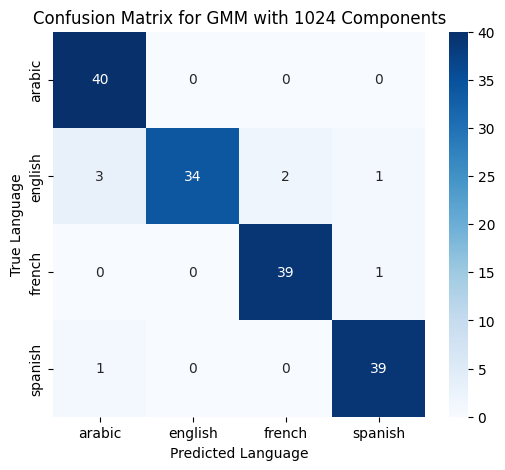

In [107]:
test_data_root = r"C:\Users\wiame\Documents\1_SEMESTER_8\SYNTHESE VOCALE\PROJECT\testing audios 4"
model_dir = r"C:\Users\wiame\Documents\1_SEMESTER_8\SYNTHESE VOCALE\PROJECT\GMM_models_normalized"
results = evaluate_gmm_models(test_data_root, model_dir, n_components_list=[8, 16, 32, 64, 128, 256, 512, 1024])

### Accuracy du test avec toutes les langues


Evaluating GMM models with 8 components...


Testing 8 components: 100%|██████████████████████████████████████████████████████████| 238/238 [01:23<00:00,  2.85it/s]


Accuracy with 8 Gaussians: 66.81%


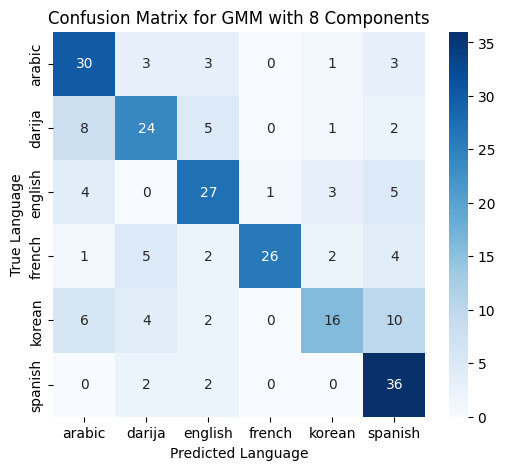


Evaluating GMM models with 16 components...


Testing 16 components: 100%|█████████████████████████████████████████████████████████| 238/238 [01:08<00:00,  3.48it/s]


Accuracy with 16 Gaussians: 65.55%


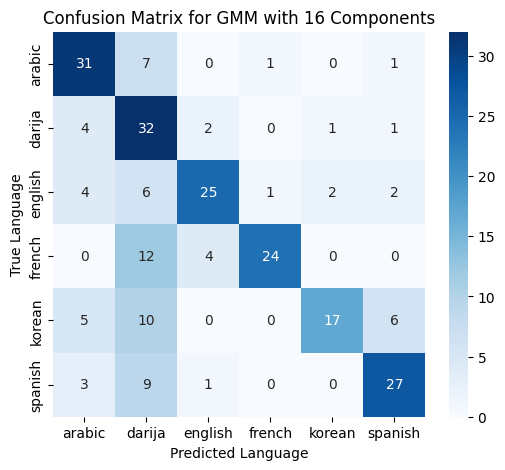


Evaluating GMM models with 32 components...


Testing 32 components: 100%|█████████████████████████████████████████████████████████| 238/238 [01:09<00:00,  3.42it/s]


Accuracy with 32 Gaussians: 70.59%


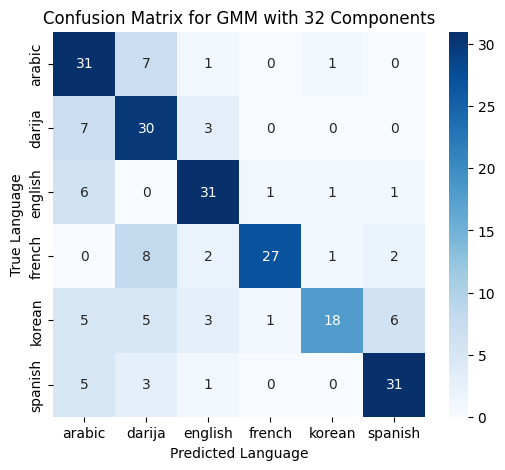


Evaluating GMM models with 64 components...


Testing 64 components: 100%|█████████████████████████████████████████████████████████| 238/238 [01:12<00:00,  3.30it/s]


Accuracy with 64 Gaussians: 73.95%


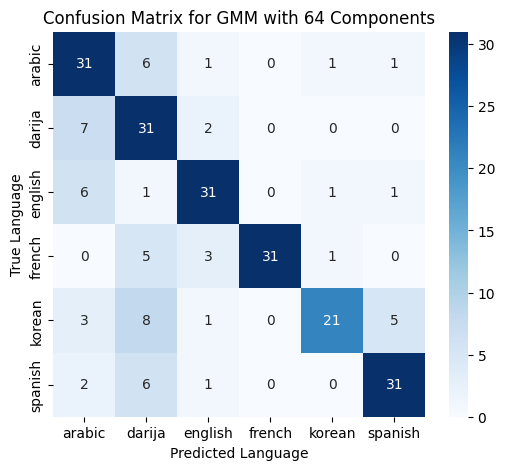


Evaluating GMM models with 128 components...


Testing 128 components: 100%|████████████████████████████████████████████████████████| 238/238 [01:11<00:00,  3.32it/s]


Accuracy with 128 Gaussians: 77.73%


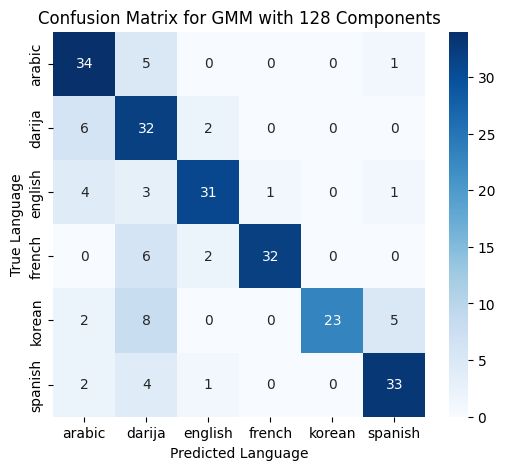


Evaluating GMM models with 256 components...


Testing 256 components: 100%|████████████████████████████████████████████████████████| 238/238 [01:41<00:00,  2.35it/s]


Accuracy with 256 Gaussians: 79.83%


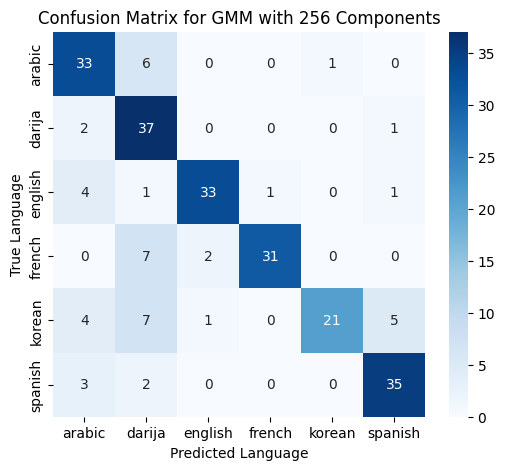


Evaluating GMM models with 512 components...


Testing 512 components: 100%|████████████████████████████████████████████████████████| 238/238 [02:04<00:00,  1.91it/s]


Accuracy with 512 Gaussians: 81.09%


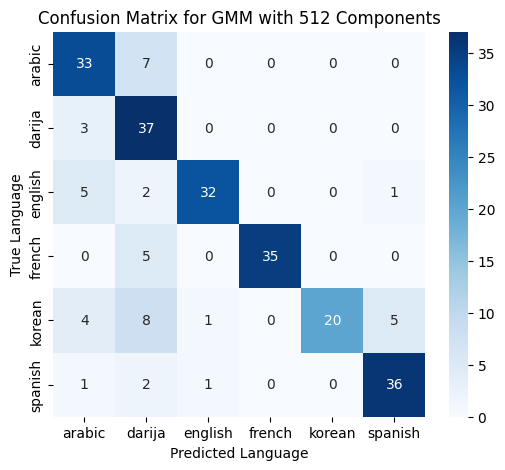


Evaluating GMM models with 1024 components...


Testing 1024 components: 100%|███████████████████████████████████████████████████████| 238/238 [03:17<00:00,  1.20it/s]


Accuracy with 1024 Gaussians: 80.67%


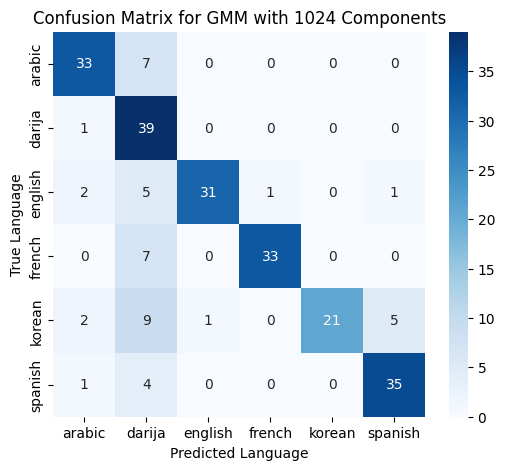

In [109]:
test_data_root = r"C:\Users\wiame\Documents\1_SEMESTER_8\SYNTHESE VOCALE\PROJECT\testing audios"
model_dir = r"C:\Users\wiame\Documents\1_SEMESTER_8\SYNTHESE VOCALE\PROJECT\GMM_models_normalized"
results = evaluate_gmm_models(test_data_root, model_dir, n_components_list=[8, 16, 32, 64, 128, 256, 512, 1024])

### Test avec une seule combinaison 

In [21]:
def evaluate_custom_gmm_combination(test_path, model_base_path, gmm_choice_per_lang):
    
    class_names = sorted(gmm_choice_per_lang.keys())
    label_map = {lang.lower(): idx for idx, lang in enumerate(class_names)}

    file_paths = []
    true_labels = []
    for lang in class_names:
        lang_path = os.path.join(test_path, lang)
        if not os.path.exists(lang_path):
            print(f"⚠ Missing test folder for {lang}")
            continue
        for fname in os.listdir(lang_path):
            if fname.endswith(".wav"):
                file_paths.append(os.path.join(lang_path, fname))
                true_labels.append(label_map[lang.lower()])

    true_labels = np.array(true_labels)
    predictions = []

    gmm_models = {}
    for lang, n_components in gmm_choice_per_lang.items():
        model_filename = f"{lang}_gmm_{n_components}.joblib"
        model_path = os.path.join(model_base_path, model_filename)

        print(f"Looking for: {model_path}")
        if os.path.exists(model_path):
            gmm_models[lang.lower()] = joblib.load(model_path)
        else:
            print(f"⚠ Model not found for {lang} with {n_components} components → {model_path}")

    print(f"\nEvaluating with custom GMM setup: {gmm_choice_per_lang}")

    for path in tqdm(file_paths, desc="Testing"):
        features = extract_features(path)
        if features.shape[0] == 0:
            predictions.append(-1)
            continue

        scores = {lang: gmm.score(features) for lang, gmm in gmm_models.items()}
        predicted_lang = max(scores, key=scores.get)
        predictions.append(label_map[predicted_lang.lower()])

    valid_idx = [i for i, p in enumerate(predictions) if p != -1]
    predictions = [predictions[i] for i in valid_idx]
    valid_true = [true_labels[i] for i in valid_idx]

    acc = accuracy_score(valid_true, predictions)
    cm = confusion_matrix(valid_true, predictions)

    print(f"\n✅ Accuracy: {acc*100:.2f}%")
    print("Confusion Matrix:")
    print(cm)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title("Confusion Matrix (Custom GMMs)")
    plt.xlabel("Predicted Language")
    plt.ylabel("True Language")
    plt.tight_layout()
    plt.show()

Looking for: C:\Users\wiame\Documents\1_SEMESTER_8\SYNTHESE VOCALE\PROJECT\GMM_models_normalized\Arabic_gmm_512.joblib
Looking for: C:\Users\wiame\Documents\1_SEMESTER_8\SYNTHESE VOCALE\PROJECT\GMM_models_normalized\English_gmm_1024.joblib
Looking for: C:\Users\wiame\Documents\1_SEMESTER_8\SYNTHESE VOCALE\PROJECT\GMM_models_normalized\Darija_gmm_256.joblib
Looking for: C:\Users\wiame\Documents\1_SEMESTER_8\SYNTHESE VOCALE\PROJECT\GMM_models_normalized\French_gmm_1024.joblib
Looking for: C:\Users\wiame\Documents\1_SEMESTER_8\SYNTHESE VOCALE\PROJECT\GMM_models_normalized\Korean_gmm_1024.joblib
Looking for: C:\Users\wiame\Documents\1_SEMESTER_8\SYNTHESE VOCALE\PROJECT\GMM_models_normalized\Spanish_gmm_1024.joblib

Evaluating with custom GMM setup: {'Arabic': 512, 'English': 1024, 'Darija': 256, 'French': 1024, 'Korean': 1024, 'Spanish': 1024}


Testing: 100%|███████████████████████████████████████████████████████████████████████| 238/238 [01:11<00:00,  3.35it/s]


✅ Accuracy: 81.93%
Confusion Matrix:
[[36  2  0  0  0  2]
 [ 9 25  3  0  1  2]
 [ 3  0 34  2  0  1]
 [ 0  3  0 37  0  0]
 [ 1  3  2  0 25  7]
 [ 2  0  0  0  0 38]]


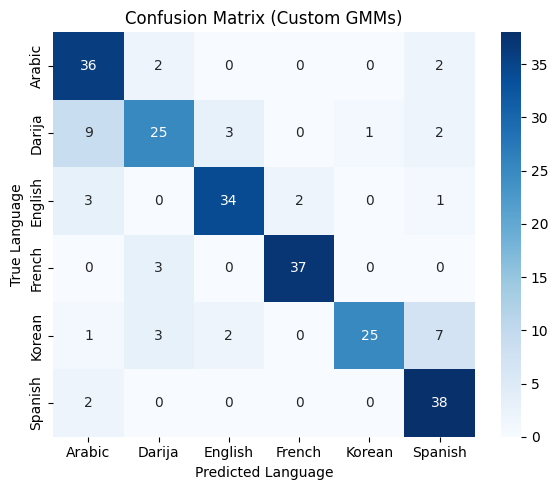

In [71]:
gmm_choice = {
    'Arabic': 512,
    'English': 1024,
    'Darija': 256,
    'French': 1024,
    'Korean': 1024,
    'Spanish': 1024,
   }
evaluate_custom_gmm_combination(r"C:\Users\wiame\Documents\1_SEMESTER_8\SYNTHESE VOCALE\PROJECT\testing audios", 
                                r"C:\Users\wiame\Documents\1_SEMESTER_8\SYNTHESE VOCALE\PROJECT\GMM_models_normalized", gmm_choice)